# Different categories of RNN models:

 - Many-to-one (sentiment analysis, fake news detection)
 - many-to-many (i.e. seq2seq, machine translation, text summary)
 - one-to-many (image captioning), one-to-one (plain MLP networks)
 

We previously looked at a many-to-one model for a sentiment analysis task (the IMDB dataset), and now let's dive into a more complicated type of RNN: many-to-many, i.e. seq2seq.

# Import packages and download data

Dataset introduction: 

This [dataset](https://www.manythings.org/anki/) consists of many combinations of bilingual sentence pairs. The lengths of the sentences and the vocabulary sizes are relatively small. In this notebook, we choose the subset of English-French sentence pairs. 

Main steps of notebook include:
 - Preprocess raw text data (regex data cleaning, deciding max lengths, tokenizer training)
 - Model setup for training (using keras functional API instead of sequential API)
 - Model setup for predictions



In [1]:
import pathlib
import random
import string
import math
import re
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchtext
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import time
import os 

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# set seed
seed_everything(940)

# setup GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # check is GPU is available

In [2]:
from torchtext.datasets import IWSLT2016

# a dataset for machine translation (English to French)
raw_text = IWSLT2016(root='./', split=('train', 'valid', 'test'), language_pair=('en','fr'), valid_set='tst2013', test_set='tst2014')
train = raw_text[0]
valid = raw_text[1]
test = raw_text[2]

100%|██████████| 188M/188M [00:01<00:00, 109MB/s]


In [4]:
print('# of training examples:', len(train))
print('# of validation examples:',len(valid))
print("# of test examples:", len(test))

# of training examples: 220400
# of validation examples: 1026
# of test examples: 1305


# Preprocess raw text data

In this section, we will perform standard text preprocessing such as lowercasing characters, removing miscellaneous symbols, standardize whitespace symbols. A majority of the work is done using the regular expression library of python. Then we will train a tokenizer from scratch.  

### RegEx preprocessing

In [ ]:
# lists for storing data
text_tr = []
text_val = []
text_test = []

for eng, fra in train:
    text_tr.append((eng,fra))

for eng, fra in valid:
    text_val.append((eng,fra))

for eng, fra in test:
    text_test.append((eng,fra))

In [ ]:
import unicodedata

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(s,verbose=False):
    if verbose:
        print(s)

    # convert characters to lowercase
    # convert characters to ascii for regex preprocessing
    s = unicode_to_ascii(s.lower())
    if verbose:
        print(s)

    # Remove the characters - <>()|&©ø"',;?~*!
    s = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", r" ", s)
    if verbose:
        print(s)

    # remove punctuations at the end of a word
    s = re.sub("(\.\s+)", r" ", s)
    s = re.sub("(\-\s+)", r" ", s)
    s = re.sub("(\:\s+)", r" ", s)
    s = re.sub("(\!\s+)", r" ", s)
    if verbose:
        print(s)

    # remove other characters that are not letters 
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    if verbose:
        print(s)

    # remove multiple whitespaces
    s = re.sub(r'(\s+)', r' ', s)
    if verbose:
        print(s)

    # Remove the single character hanging between any two spaces
    s = re.sub("(\s+.\s+)", r" ", s)
    if verbose:
        print(s)

    # removes whitespaces in the beginning and the end
    s = s.strip()
    if verbose:
        print(s)

    # add start and end of sentence tokens
    s = '[SOS]' +' '+ s +' '+'[EOS]'
    return s

s = '  1234 reguLAR eXpreSSion sooo\t hard!!! - <>()|&©ø"\',;?~*   '
preprocess_sentence(s,verbose=True)

  1234 reguLAR eXpreSSion sooo	 hard!!! - <>()|&©ø"',;?~*   
  1234 regular expression sooo	 hard!!! - <>()|&©ø"',;?~*   
  1234 regular expression sooo	 hard    -                   
  1234 regular expression sooo	 hard     
 regular expression sooo hard 
 regular expression sooo hard 
 regular expression sooo hard 
regular expression sooo hard


'[SOS] regular expression sooo hard [EOS]'

Clean raw text using regex

In [ ]:
def process_corpus(lang):
    # list to store preprocessed text
    lang_eng = []
    lang_fra = []

    # preprocess raw text
    for eng, fra in lang:
        preprocessed_eng = preprocess_sentence(eng)
        preprocessed_fra = preprocess_sentence(fra)
        lang_eng.append(preprocessed_eng)
        lang_fra.append(preprocessed_fra)
    
    return lang_eng, lang_fra


In [ ]:
lang_eng_tr, lang_fra_tr = process_corpus(text_tr)
lang_eng_val, lang_fra_val = process_corpus(text_val)
lang_eng_test, lang_fra_test = process_corpus(text_test)

In [ ]:
lang_eng_tr[0:5]

['[SOS] david gallo this is bill lange m dave gallo [EOS]',
 '[SOS] and we re going to tell you some stories from the sea here in video [EOS]',
 '[SOS] we ve got some of the most incredible video of titanic that ever been seen and we re not going to show you any of it [EOS]',
 '[SOS] the truth of the matter is that the titanic even though it breaking all sorts of box office records it not the most exciting story from the sea [EOS]',
 '[SOS] and the problem think is that we take the ocean for granted [EOS]']

In [ ]:
lang_fra_tr[0:5]

['[SOS] david gallo voici bill lange je suis dave gallo [EOS]',
 '[SOS] nous allons vous raconter quelques histoires de la mer en video [EOS]',
 '[SOS] nous avons des videos du titanic parmi les plus spectaculaires jamais vues et nous allons pas vous en montrer une image [EOS]',
 '[SOS] la verite est que le titanic meme il continue de battre toutes les records de recettes est pas histoire la plus passionnante [EOS]',
 '[SOS] le probleme je crois est qu on tient ocean pour acquis [EOS]']

In [ ]:
del text_tr; del text_val; del text_test;

### Select sentences that are shorter than the maximum lengths allowed

In a large dataset, it is possible that a very few sentences are very lengthy, while the remaining majority are much shorter. In this case, if we keep those lengthy sentences, then we need to zero pad the remaining ones up to the same length, which requires the machine to store a lot of zeros for nothing. To avoid this, we simply look at the distribution of lengths for both languages, and regulate the max lengths. 

In [ ]:
# count lengths of sentences in english and french
eng_lengths = np.array([len(sentence.split()) for sentence in lang_eng_tr])
fra_lengths = np.array([len(sentence.split()) for sentence in lang_fra_tr])

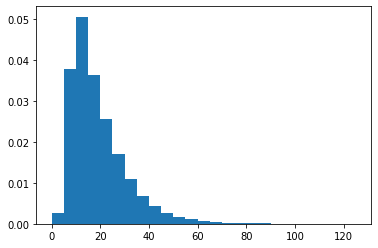

In [ ]:
plt.hist(eng_lengths,bins=np.arange(0,130,5),density=True);

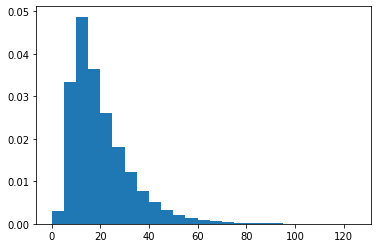

In [ ]:
plt.hist(fra_lengths,bins=np.arange(0,130,5),density=True);

After looking at the histograms, we can restrict the length of English sentences to 80, and the length of French sentences to 80.

In [ ]:
# condition of a pair getting selected
def select_sentence_pair(row):
    # selected if both sentences are shorter than the max lengths
    if len(row.iloc[0].split()) < max_length_inp and len(row.iloc[1].split()) < max_length_targ:
        return 1
    else:
        return 0

# hard coded max lengths
max_length_targ, max_length_inp = 80, 80

# delete sentences exceeding max lengths
def filter_text(lang_eng, lang_fra):
    # put two lists into a df to select pairs
    cleaned_text = pd.DataFrame({'eng_cleaned':lang_eng,'fra_cleaned':lang_fra})

    keep = cleaned_text.apply(select_sentence_pair,axis=1)
    cleaned_text['keep'] = keep

    # filter out unwanted data 
    cleaned_text = cleaned_text[cleaned_text.keep == 1]

    lang_eng_new = cleaned_text.iloc[:,0].tolist()
    lang_fra_new = cleaned_text.iloc[:,1].tolist()

    return lang_eng_new, lang_fra_new
  
lang_eng_tr, lang_fra_tr = filter_text(lang_eng_tr, lang_fra_tr)
lang_eng_val, lang_fra_val = filter_text(lang_eng_val, lang_fra_val)
lang_eng_test, lang_fra_test = filter_text(lang_eng_test, lang_fra_test)

In [ ]:
print('# of training examples after filter:', len(lang_eng_tr))
print('# of validation examples after filter:',len(lang_eng_val))
print('# of test examples after filter:',len(lang_eng_test))
#print("# of test examples:", len(test))

# of training examples after filter: 219562
# of validation examples after filter: 1022
# of test examples after filter: 1304


###  Detect empty sentences

If any empty sentence detected in a pair, then we will delete that pair from the data.

In [ ]:
def detect_empty_sentences(lang_eng, lang_fra):
    # detect if there are any empty sentences,i.e, which only have '<start>' and '<end>' tokens
    eng_ind = []

    # for each sentence in the corpus
    for i in range(len(lang_eng)):
        
        for j in lang_eng[i].split():
            if j == '[SOS]':
                empty = True
            elif j == '[EOS]' and empty:
                eng_ind.append(i)
                #print('empty English sentence detected! index:',i)
            else: 
                empty = False
        
    print('# of empty English sentences:', len(eng_ind))

    fra_ind = []

    # for each sentence in the corpus
    for i in range(len(lang_fra)):
        
        for j in lang_fra[i].split():
            if j == '[SOS]':
                empty = True
            elif j == '{[EOS]}' and empty:
                fra_ind.append(i)
                #print('empty French sentence detected! index:',i)
            else: 
                empty = False
        
    print('# of empty French sentences:', len(fra_ind))

    final_ind = set(eng_ind + fra_ind)

    print('# of datapoints to be deleted:', len(final_ind))

    return list(final_ind)

In [ ]:
print('detecting empty sentences in training data')

delete_idx = detect_empty_sentences(lang_eng_tr, lang_fra_tr)

# delete unwanted sentences
lang_eng_tr = [lang_eng_tr[i] for i in range(len(lang_eng_tr)) if i not in delete_idx]
lang_fra_tr = [lang_fra_tr[i] for i in range(len(lang_fra_tr)) if i not in delete_idx]

print()
print('detecting empty sentences in validation data')

delete_idx = detect_empty_sentences(lang_eng_val, lang_fra_val)

# delete unwanted sentences
lang_eng_val = [lang_eng_val[i] for i in range(len(lang_eng_val)) if i not in delete_idx]
lang_fra_val = [lang_fra_val[i] for i in range(len(lang_fra_val)) if i not in delete_idx]

print()
print('detecting empty sentences in test data')

delete_idx = detect_empty_sentences(lang_eng_test, lang_fra_test)

# delete unwanted sentences
lang_eng_test = [lang_eng_test[i] for i in range(len(lang_eng_test)) if i not in delete_idx]
lang_fra_test = [lang_fra_test[i] for i in range(len(lang_fra_test)) if i not in delete_idx]

detecting empty sentences in training data
# of empty English sentences: 20
# of empty French sentences: 0
# of datapoints to be deleted: 20

detecting empty sentences in validation data
# of empty English sentences: 0
# of empty French sentences: 0
# of datapoints to be deleted: 0

detecting empty sentences in test data
# of empty English sentences: 0
# of empty French sentences: 0
# of datapoints to be deleted: 0


### Tokenizer training 

Here we use a SOTA tokenizer training algorithm, and we are manually regulating the vocabulary sizes.

In [6]:
%%capture
!pip install tokenizers
from tokenizers import Tokenizer

In [ ]:
from tokenizers.models import WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer

# one tokenizer for each language
eng_tokenizer = Tokenizer(WordPiece())
fra_tokenizer = Tokenizer(WordPiece())

eng_tokenizer.pre_tokenizer = Whitespace()
fra_tokenizer.pre_tokenizer = Whitespace()

def yield_text(data_iter):
    '''Creates a generator for all texts in one language'''

    for text in data_iter:
        yield text

trainer = WordPieceTrainer(vocab_size=10000, special_tokens=['[UNK]','[SOS]','[EOS]'])

eng_tokenizer.train_from_iterator(lang_eng_tr, trainer=trainer)
fra_tokenizer.train_from_iterator(lang_fra_tr, trainer=trainer)

In [7]:
# save tokenizers
#eng_tokenizer.save("./eng_tok.json")
#fra_tokenizer.save("./fra_tok.json")

# load tokenizers
eng_tokenizer = Tokenizer.from_file("./eng_tok.json")
fra_tokenizer = Tokenizer.from_file("./fra_tok.json")

In [4]:
print(eng_tokenizer.id_to_token(0),eng_tokenizer.id_to_token(1),eng_tokenizer.id_to_token(2))

[UNK] [SOS] [EOS]


In [5]:
print(fra_tokenizer.id_to_token(0),fra_tokenizer.id_to_token(1),fra_tokenizer.id_to_token(2))

[UNK] [SOS] [EOS]


In [8]:
# vocab sizes for two langauges
vocab_eng_size = eng_tokenizer.get_vocab_size()
vocab_fra_size = fra_tokenizer.get_vocab_size()

In [ ]:
# now preprocessing is finished, store all data into csv files and release memory

train_df = pd.DataFrame({'eng':lang_eng_tr,'fra':lang_fra_tr})
valid_df = pd.DataFrame({'eng':lang_eng_val,'fra':lang_fra_val})
test_df = pd.DataFrame({'eng':lang_eng_test,'fra':lang_fra_test})

train_df.to_csv('train_df.csv',index=False)
valid_df.to_csv('valid_df.csv',index=False)
test_df.to_csv('test_df.csv',index=False)

del train_df; del valid_df; del test_df; del lang_eng_tr; del lang_fra_tr; del lang_eng_val
del lang_fra_val; del lang_eng_test; del lang_fra_test;
gc.collect()

# Datasets and data loaders

### Datasets

In [17]:
class TextDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # if the indices passed in are in a tensor, convert to list
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # extract rows of the passed indicies and convert to arrays
        if isinstance(idx,list):
            eng = self.data.iloc[idx,0].values
            fra = self.data.iloc[idx,1].values
        else: 
            eng = np.array([self.data.iloc[idx,0]])
            fra = np.array([self.data.iloc[idx,1]])
        
        sample = {'eng':eng,'fra':fra}

        return sample

train_set = TextDataset('train_df.csv')
valid_set = TextDataset('valid_df.csv')

### Pipelines

In [18]:
def cut(x, maxlen=80):
    return x[0:maxlen] if len(x) > maxlen else x

def eng_pipeline(text):
    text = eng_tokenizer.encode(text).ids
    #text = cut(text, maxlen=max_length_inp)
    return text

def fra_pipeline(text):
    text = fra_tokenizer.encode(text).ids
    #text = cut(text, maxlen=max_length_targ)
    return text

### Collate function and data loaders

In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    '''
    Transforms texts and labels according to corresponding pipelines,
    zero pad shorter sequences, and stack all sequences in the batch along a new axis'''

    eng_list, fra_list = [], []

    for pair in batch:
        assert len(pair['eng']) == 1, 'length of one value in dict more than 1!'
        
        eng = pair['eng'][0]
        fra = pair['fra'][0]
        
        # convert text to sequences, then make them tensors
        eng_seq = torch.LongTensor(eng_pipeline(eng))
        fra_seq = torch.LongTensor(fra_pipeline(fra))

        # append sequences to lists
        eng_list.append(eng_seq)
        fra_list.append(fra_seq)

    # pad sequences to desired lengths
    inp_tensor = pad_sequence(eng_list,batch_first=True)
    targ_tensor = pad_sequence(fra_list,batch_first=True)

    # move tensors to device
    return inp_tensor.to(device), targ_tensor.to(device)

BSZ = 128

train_loader = DataLoader(train_set,batch_size=BSZ,collate_fn=collate_batch,shuffle=True)
valid_loader = DataLoader(valid_set,batch_size=BSZ,collate_fn=collate_batch,shuffle=False)

# Encoder-decoder model using LSTM

Here we are going to use **teacher forcing** for training, which means the correct token of the target language is passed into the decoder, and then the decoder predicts the next token. If without teacher forcing, the previously decoder-predicted token is passed into the decoder as the current step input.

Different from the keras notebook, where we had two instances of the decoder, here we only have one, because we'll make the decoder process one token at a time. That way, the same decoder instance will function properly during both training and prediction. Also, this makes it possible to stochastically impose teacher forcing to the model, because now we can make the algorithm randomly choose between output token from previous step or the true token of the current step, since the decoder processes one token at a time.

### Build model

In [20]:
EMBED_DIM = 256
HIDDEN_DIM = 512

In [21]:
class Encoder(nn.Module):
    def __init__(self,embed_dim,hidden_dim,lstm_layers=3,dropout=0.4):
        super().__init__()
        self.hidden_dim = hidden_dim  
        self.lstm_layers = lstm_layers 

        self.embedding = nn.Embedding(vocab_eng_size,embed_dim,padding_idx=0)
        
        self.lstm = nn.LSTM(embed_dim,hidden_dim,lstm_layers,
                            dropout=dropout,batch_first=True)
        
        
    def forward(self,seq):
        emb = self.embedding(seq)
        lstm_out,(hidden,cell) = self.lstm(emb)
        # size of h & c: (n layers, batch size, hidden dim)

        return (hidden,cell)

The decoder processes one token at a time, rather than the whole sequence.

In [22]:
class Decoder(nn.Module):
    def __init__(self,embed_dim,hidden_dim,lstm_layers=3,dropout=0.4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        self.embedding = nn.Embedding(vocab_fra_size,embed_dim,padding_idx=0)
        
        self.lstm = nn.LSTM(embed_dim,hidden_dim,lstm_layers,
                            dropout=dropout,batch_first=True)
        
        self.fc_head = nn.Linear(hidden_dim,vocab_fra_size)

    def forward(self,tok,hidden,cell):
        
        tok = tok.unsqueeze(1)
        # tok: (batch size, 1)

        emb = self.embedding(tok)
        lstm_out,(hidden,cell) = self.lstm(emb,(hidden,cell))
        # lstm_out: (batch size, 1, hidden dim)
        # hidden & cell: (n layers, batch size, hidden dim)

        pred = self.fc_head(lstm_out.squeeze(1))
        # pred: (batch size, vocab size of target lang)

        return (pred, hidden, cell)

In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.hidden_dim == decoder.hidden_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.lstm_layers == decoder.lstm_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self,inp,trg,teacher_forcing_ratio=0.5):
        # teacher forcing ratio: probability to use teacher forcing
        bsz = trg.shape[0]
        trg_len = trg.shape[1]

        # tensor to store output tokens from decoder later
        outputs = torch.zeros(bsz,trg_len,vocab_fra_size).to(device)

        # encode input sequence and get states
        hidden, cell = self.encoder(inp)

        # input to decoder: the start of sequence tokens
        dec_in = trg[:,0]
        
        # for each time step
        for t in range(1,trg_len):
            # decoder outputs one token
            output,hidden,cell = self.decoder(dec_in,hidden,cell)
            outputs[:,t,:] = output

            # decide if we use teacher forcing at this time step
            teacher_force = random.random() < teacher_forcing_ratio

            # get the token with the highest pred prob
            top1 = output.argmax(1)

            # if teacher forcing, use actual next token as next input token to decoder
            # if not, use predicted token
            dec_in = trg[:,t] if teacher_force else top1
        
        return outputs


In [25]:
enc = Encoder(EMBED_DIM,HIDDEN_DIM)
dec = Decoder(EMBED_DIM,HIDDEN_DIM)
net = Seq2Seq(enc,dec).to(device)

Use the `apply` method of our model `net`, to apply a function to every sub-module of `net`. For each module, we loop over all parameters and sample them from a uniform distribution.

### Train model

Just like the previous LSTM tutorial, we separately code functions for initializing weights, training, validation, and other supporting tasks to make the main training code concise. 

We also implement a basic early stopping algorithm that monitors the validation loss per epoch.




In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
net.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256, padding_idx=0)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.4)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256, padding_idx=0)
    (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.4)
    (fc_head): Linear(in_features=512, out_features=10000, bias=True)
  )
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(net):,} trainable parameters')

The model has 21,808,912 trainable parameters


In [28]:
def train(net, dataloader, optimizer, criterion, clip, force=1):
    net.train()
    loss_list = []
    log_interval = 250
    start_time = time.time()

    for idx, (inp_seq, targ_seq) in enumerate(dataloader):

        optimizer.zero_grad()

        # forward pass 
        output = net(inp_seq,targ_seq,force)
        # output: (batch size, targ len, targ vocab size)
        # targ_seq: (batch size, targ len)

        # get rid of the sos tokens
        # reshape output and target sequence for loss calculation
        output = output[:,1:,:].reshape(-1,vocab_fra_size)
        targ_seq = targ_seq[:,1:].reshape(-1)
        # output: (batch size * (targ len-1), targ vocab size)
        # targ_seq: (batch size * (targ len-1),)

        # compute loss
        loss = criterion(output, targ_seq)
        loss.backward()
        loss_list.append(loss.item())

        # clip gradients
        nn.utils.clip_grad_norm_(net.parameters(),clip)
        optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            last_few_losses = np.mean(np.array(loss_list))
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:.6f} '.format(epoch, idx, len(dataloader), 
                                              last_few_losses))
            total_acc, total_count = 0, 0
            loss_list = []
            start_time = time.time()

In [29]:
def evaluate(net, dataloader, criterion):
    net.eval()
    loss_list = []

    with torch.no_grad():
        for idx, (inp_seq, targ_seq) in enumerate(dataloader):
                      
            # turn off teacher forcing
            output = net(inp_seq,targ_seq,teacher_forcing_ratio=0)

            output = output[:,1:,:].reshape(-1,vocab_fra_size)
            targ_seq = targ_seq[:,1:].reshape(-1)
            loss = criterion(output, targ_seq)
            loss_list.append(loss.item())
    
    # return validation loss 
    return np.mean(np.array(loss_list))

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
# early stopping class for monitoring valid loss

class EarlyStop:
    def __init__(self,net_save_path,patience=2,delta=1e-3):
        self.best_loss = math.inf # initialize to +infty
        self.patience = patience  # how many bad epochs we tolerate
        self.count = 0       # count of bad epochs
        self.delta = delta   # threshold to determine significance of decrease in valid loss
        self.path = net_save_path
        self.stop = False

    def step(self,valid_loss,net):
        '''Decides whether to stop training according to the current valid loss,
           the best valid loss, and the count of bad epochs'''

        # if stop condition satisfied already, skip 
        if self.stop == True:
            return 

        # if valid loss decreases (significantly w.r.t. delta)
        if (valid_loss<self.best_loss) and (math.fabs(valid_loss-self.best_loss)>self.delta):
            # update best valid loss
            self.best_loss = valid_loss
            # reset count of bad epochs
            self.count = 0
            # save current model as best model
            torch.save(net.state_dict(),self.path)
        else:
            # count of bad epochs +1, i.e. the current epoch makes the model worse
            self.count += 1
        
        # if count of bad epochs exceeds patience
        if self.count >= self.patience:
            # status updated to stop
            self.stop = True

    def get_best_model(self,net):
        net.load_state_dict(torch.load(self.path))
    

In [32]:
LR = 5e-4

criterion = nn.CrossEntropyLoss()

# stochastic gradient descent as optimizer
optimizer = optim.Adam(net.parameters(), lr=LR)

# early stopping
es = EarlyStop('seq2seq_eng_fra.pt')

In [33]:
EPOCHS = 10
CLIP = 1
TEACHER_FORCE = 0.8

for epoch in range(1, EPOCHS + 1):
    # record starting time of the epoch
    epoch_start_time = time.time()

    train(net, train_loader, optimizer, criterion, CLIP, TEACHER_FORCE)
    valid_loss = evaluate(net, valid_loader, criterion)

    epoch_end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(epoch_start_time,epoch_end_time)

    # update early stopper
    es.step(valid_loss, net)

    print('-' * 90)
    print('| end of epoch {:3d} | time: {:2d}m {:2d}s '
          '| valid loss {:.6f} '.format(epoch,
                                        epoch_mins, epoch_secs,
                                        valid_loss))
    print('-' * 90)

    # check condition of early stop
    if es.stop == True:
        print('\nearly stopped!')
        break

| epoch   1 |   250/ 1716 batches | loss 2.197274 
| epoch   1 |   500/ 1716 batches | loss 1.938137 
| epoch   1 |   750/ 1716 batches | loss 1.863558 
| epoch   1 |  1000/ 1716 batches | loss 1.790545 
| epoch   1 |  1250/ 1716 batches | loss 1.758188 
| epoch   1 |  1500/ 1716 batches | loss 1.689692 
------------------------------------------------------------------------------------------
| end of epoch   1 | time: 22m 28s | valid loss 2.274353 
------------------------------------------------------------------------------------------
| epoch   2 |   250/ 1716 batches | loss 1.647736 
| epoch   2 |   500/ 1716 batches | loss 1.625399 
| epoch   2 |   750/ 1716 batches | loss 1.618799 
| epoch   2 |  1000/ 1716 batches | loss 1.601477 
| epoch   2 |  1250/ 1716 batches | loss 1.582836 
| epoch   2 |  1500/ 1716 batches | loss 1.561684 
------------------------------------------------------------------------------------------
| end of epoch   2 | time: 22m 32s | valid loss 2.160695 

# Predictions


### Load Best Model

In [34]:
enc = Encoder(EMBED_DIM,HIDDEN_DIM)
dec = Decoder(EMBED_DIM,HIDDEN_DIM)
net = Seq2Seq(enc,dec).to(device)

#net.load_state_dict(torch.load('./seq2seq_eng_fra.pt'))
es.get_best_model(net)

### Prediction setup



In [35]:
def collate_batch_with_raw(batch):

    eng_list, fra_list = [], []
    eng_text, fra_text = [], []

    for pair in batch:
        assert len(pair['eng']) == 1, 'length of one value in dict more than 1!'
        
        eng = pair['eng'][0]
        fra = pair['fra'][0]
        eng_text.append(eng)
        fra_text.append(fra)
        
        # convert text to sequences, then make them tensors
        eng_seq = torch.LongTensor(eng_pipeline(eng))
        fra_seq = torch.LongTensor(fra_pipeline(fra))

        # append sequences to lists
        eng_list.append(eng_seq)
        fra_list.append(fra_seq)

    # pad sequences to desired lengths
    inp_tensor = pad_sequence(eng_list,batch_first=True)
    targ_tensor = pad_sequence(fra_list,batch_first=True)

    # output tensors as well as original text
    return inp_tensor.to(device), targ_tensor.to(device), eng_text, fra_text

def evaluate_and_print(net, dataloader, criterion):
    net.eval()
    loss_list = []

    with torch.no_grad():
        for idx, (inp_seq, targ_seq, eng_text, fra_text) in enumerate(dataloader):
            # turn off teacher forcing
            output = net(inp_seq,targ_seq,teacher_forcing_ratio=0)
            # output: (batch size, targ len, vocab size of targ)

            output_reshaped = output[:,1:,:].reshape(-1,vocab_fra_size)
            targ_seq_reshaped = targ_seq[:,1:].reshape(-1)
            loss = criterion(output_reshaped, targ_seq_reshaped)
            loss_list.append(loss.item())

            preds = torch.argmax(output[:,1:,:],2)
            first_seq_pred = preds[0,:].tolist()

            # print out the first example of the batch
            print('English:', ' '.join(eng_text[0].split()[1:-1]))
            print('Original French:', ' '.join(fra_text[0].split()[1:-1]))
            print('Predicted French:', fra_tokenizer.decode(first_seq_pred))
            print()
    
    # return avg validation loss 
    return np.mean(np.array(loss_list))

In [36]:
test_set = TextDataset('test_df.csv')
test_loader = DataLoader(test_set,batch_size=BSZ,collate_fn=collate_batch_with_raw,
                         shuffle=False)

### Predictions on the test set

In [37]:
test_loss = evaluate_and_print(net,test_loader,criterion).item()
print("average loss in test set:", test_loss)

English: when was in my i saw my very first psychotherapy client
Original French: quand avais la vingtaine ai vu mes tout premiers clients comme psychotherapeute
Predicted French: quand je suis arrive mon premier mon premier groupe de mon pere

English: throughout the history of computers we ve been striving to shorten the gap between us and digital information the gap between our physical world and the world in the screen where our imagination can go wild
Original French: tout au long de histoire de informatique nous avons tache de combler le fosse entre nous et le monde numerique ecart entre notre monde physique et le monde derriere notre ecran ou notre imagination peut epanouir
Predicted French: au cours de nos experiences nous avons commence nous nous avons ##ons la vie de notre vie et notre monde et la de la vie de la planete et la musique de la nature et la nature que nous pouvons nous faire

English: we forget how harsh his vision was
Original French: on oublie quel point sa vis

References:

https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

